## This notebook is used for testing MTAOS communication with the AOS components: M1M3, M2, and hexapods

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

In [13]:
%load_ext autoreload
%autoreload 2

In [ ]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

In [1]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [2]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


In [3]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

In [7]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is full (100 elements); data may be lost
timeAndDate DDS read queue is full (100 elements); data may be lost


In [8]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [6]:
await mtcs.close()

In [ ]:
mtcs.components_attr

In [10]:
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos
mount = mtcs.rem.mtmount

In [65]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

In [ ]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

In [ ]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!

In [78]:
summit = 1 #use this for summit testing
#summit = 0 #use this for NCSA

In [79]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

#### Check summary state of each CSC

In [126]:
await checkAOSSummaryStates(aos, m1m3, m2, camhex, m2hex)

starting with: MTAOS state State.ENABLED 2021-05-03 21:28:28.954629632
starting with: M1M3 state State.FAULT 2021-05-04 17:45:30.729319680
          detailed state DetailedState.FAULT 2021-05-04 17:45:30.729355008
staring with: m2 state State.ENABLED 2021-05-04 16:13:32.832608256
staring with: cam hex state State.ENABLED 2021-05-04 15:55:21.777170688
          cam hex state EnabledSubstate.STATIONARY 2021-05-04 17:46:08.839011840
staring with: M2 hex state State.ENABLED 2021-05-04 16:18:51.868910592
          hex state EnabledSubstate.STATIONARY 2021-05-04 17:37:11.393499904


### Get M1M3 Ready: raise mirorr, turn on FB, clear forces

In [59]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [60]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

Re-enabling M1M3


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [125]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  90.0
m1m3 state DetailedState.RAISING 2021-05-04 17:42:16.092666880
m1m3 state DetailedState.ACTIVE 2021-05-04 17:45:29.692252672
m1m3 z position =  0.0
Magnitude of the m1m3 force balance system 0.0


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=159848385, ack=<SalRetCode.CMD_FAILED: -302>, error=0, result='Failed: The command ApplyAberrationForces is not valid in the FaultState.')

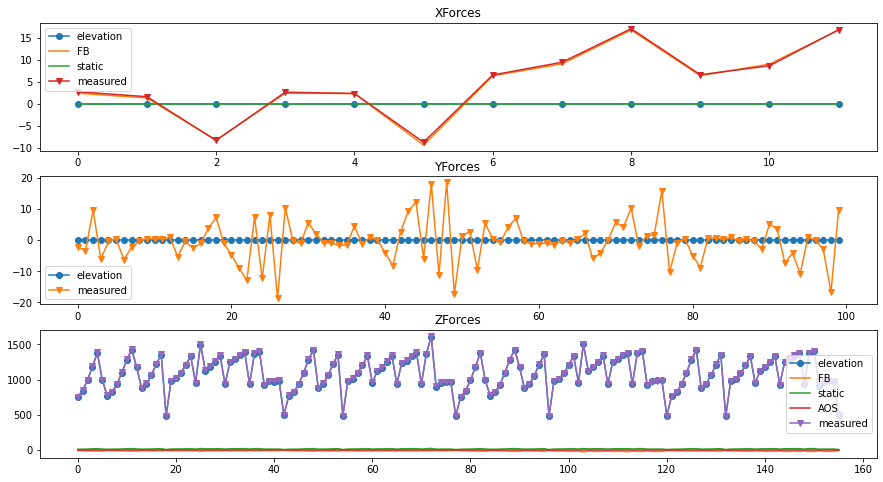

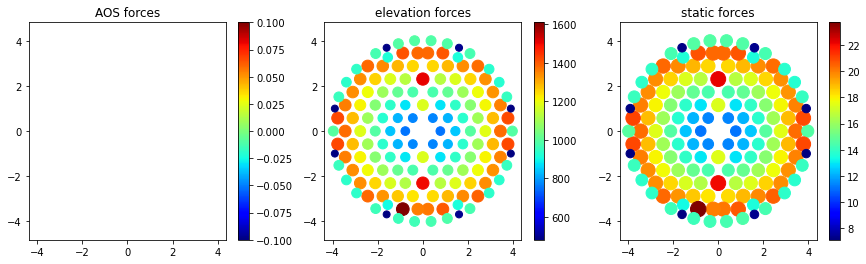

In [62]:
#%matplotlib inline
await plotM1M3Forces(m1m3)

### Get M2 Ready: turn on FB, clear forces

In [30]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [31]:
sstate = await m2.evt_summaryState.aget(timeout=5)
print('staring with: m2 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

staring with: m2 state State.STANDBY 2021-05-04 16:01:43.111081472


In [32]:
await salobj.set_summary_state(m2, salobj.State.ENABLED) 
#await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await m2.cmd_enterControl.set_start(timeout = 5.)

In [33]:
await readyM2(m2)

m2 inclinometer angle =  -0.054146490102748
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


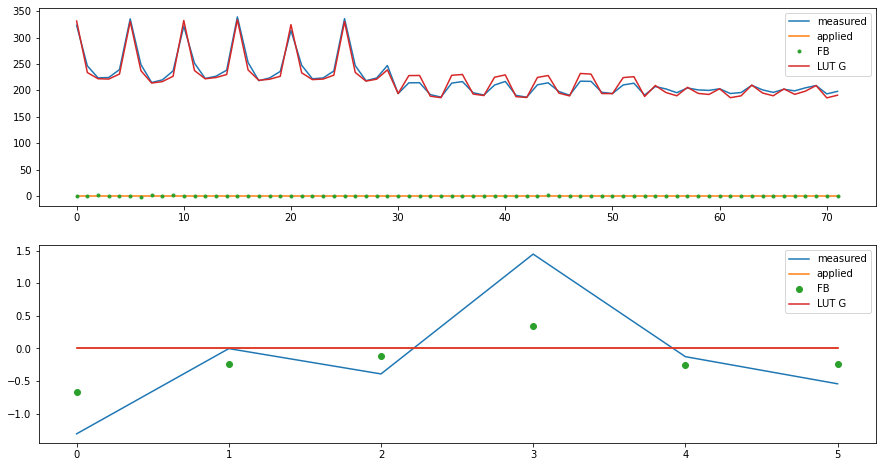

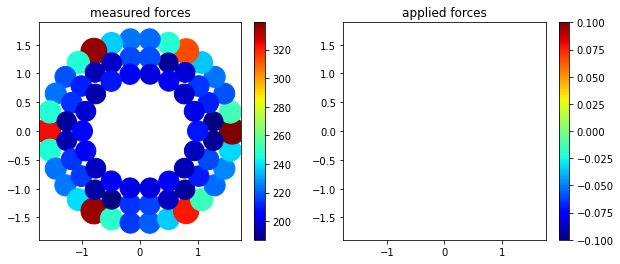

In [34]:
await plotM2Forces(m2)

### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [12]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [44]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.2-0-g4375e27 2021-05-04 15:54:36.967497472
pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled, first time: ? True 2021-05-04 15:55:28.731855104
compsensation mode enabled? True 2021-05-04 15:55:28.731855104
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  45.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.30173926111347926 274.95608572555415 35.66371782386716 0.007332027051301822 0.0 0.0
hexapod already at LUT position


In [19]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [ ]:
await camhex.cmd_exitControl.set_start(timeout=10.)

In [20]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply="default")

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [27]:
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
dstate = await camhex.evt_controllerState.aget(timeout=5)
print('          cam hex state', MTHexapod.EnabledSubstate(dstate.enabledSubstate), 
  pd.to_datetime(dstate.private_sndStamp, unit='s'))

staring with: cam hex state State.ENABLED 2021-05-04 15:55:21.777170688
          cam hex state EnabledSubstate.MOVING_POINT_TO_POINT 2021-05-04 16:08:09.905652736


In [ ]:
mount_angle = await mount.tel_elevation.next(flush=False, timeout=10.)
print("mount elevation angle", mount_angle.actualPosition)
elev = mount_angle.actualPosition

### Get M2 hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [35]:
await m2hex.evt_heartbeat.next(flush=True, timeout=5)

In [48]:
await m2hex.cmd_setCompensationMode.set_start(enable=0, timeout=10)

In [52]:
await m2hex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [55]:
await printHexaPosition(m2hex)
await printHexaUncompensatedAndCompensated(m2hex)

Current Hexapod position
     -2.41     244.23      53.62   0.002713  -0.000000   0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-04 16:38:22.025255680
Compensated position
     -2.39     244.25      53.60       0.002713   0.000000   0.000000    2021-05-04 16:38:22.025727488


In [54]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.2-0-g4375e27 2021-05-04 16:18:51.607951360
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled, first time: ? True 2021-05-04 16:28:42.474465280
compsensation mode enabled? True 2021-05-04 16:28:42.474465280
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  45.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -2.3898370654465473 244.25287511756562 53.59727796220636 0.0027134205138811714 0.0 0.0
hexa in position? False 2021-05-04 16:38:22.126828800
hexa in position? True 2021-05-04 16:38:22.229157376
Current Hexapod position
     -2.39     244.28      53.58   0.002714  -0.000000  -0.000000


In [41]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

### Step 1: add aberrations via OFC

In [63]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = 1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [64]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??
#await aos.cmd_issueCorrection.set_start() #in the future, we want to issue corrections manually

DOF event time =  2021-05-04 16:50:06.305242880
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


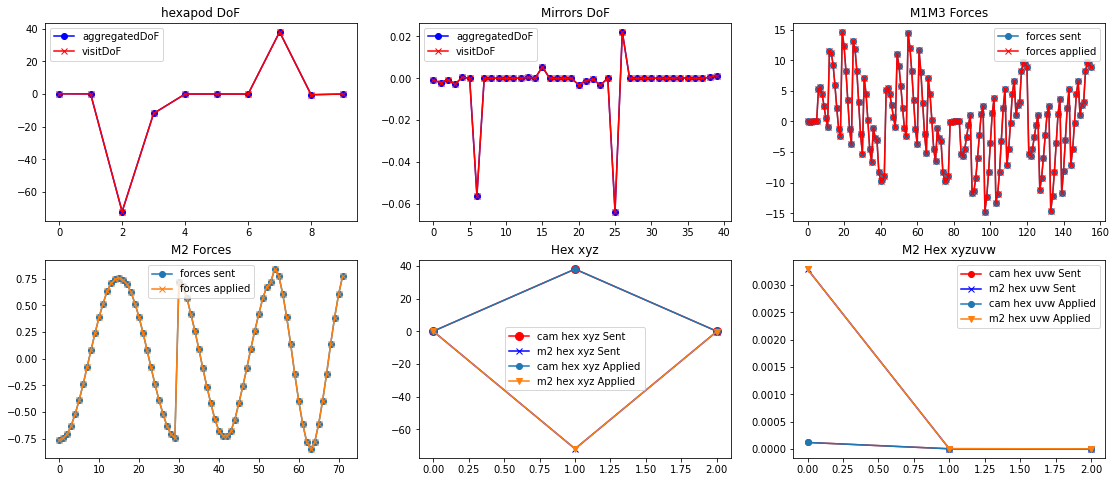

In [74]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

#### Look at telemetry to verify the changes in the DOFs

In [89]:
#end = Time(datetime.now(), scale='tai')
end = Time('2021-05-04T16:52:30', scale = 'tai')
start = end - timedelta(seconds=300)

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

electrical DDS read queue is filling: 12 of 100 elements
electrical DDS read queue is filling: 14 of 100 elements
application DDS read queue is filling: 13 of 100 elements
application DDS read queue is filling: 31 of 100 elements
actuators DDS read queue is filling: 32 of 100 elements
appliedForces DDS read queue is full (100 elements); data may be lost
appliedElevationForces DDS read queue is full (100 elements); data may be lost
appliedCylinderForces DDS read queue is full (100 elements); data may be lost
appliedBalanceForces DDS read queue is full (100 elements); data may be lost
appliedAzimuthForces DDS read queue is full (100 elements); data may be lost
appliedActiveOpticForces DDS read queue is full (100 elements); data may be lost
appliedAberrationForces DDS read queue is full (100 elements); data may be lost


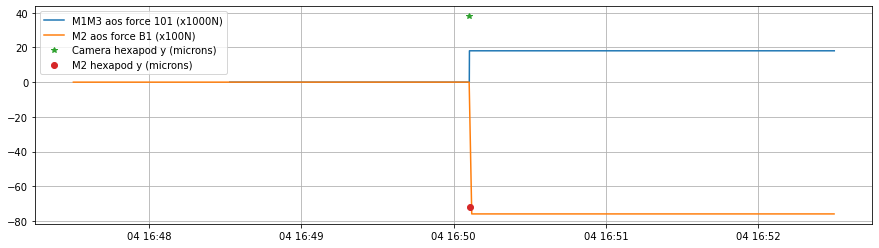

In [103]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
#plt.plot(dfm.actualPosition, '--', label='mount elevation')
plt.plot(dfm1m3.zForces0*1e3, label='M1M3 aos force 101 (x1000N)')
plt.plot(dfm2.applied0*1e2, label='M2 aos force B1 (x100N)')
plt.plot(dfh1.y, '*', label='Camera hexapod y (microns)')
plt.plot(dfh2.y, 'o', label='M2 hexapod y (microns)')
plt.grid()
plt.legend()

### Step 2: add same aberrations twice. Are the aggregateDOF accumulating?

In [104]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
10: Issue the M1M3 correction successfully.
20: Issue the M2 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-05-04 17:27:21.965652224


application DDS read queue is filling: 12 of 100 elements
electrical DDS read queue is filling: 12 of 100 elements
actuators DDS read queue is filling: 13 of 100 elements


If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


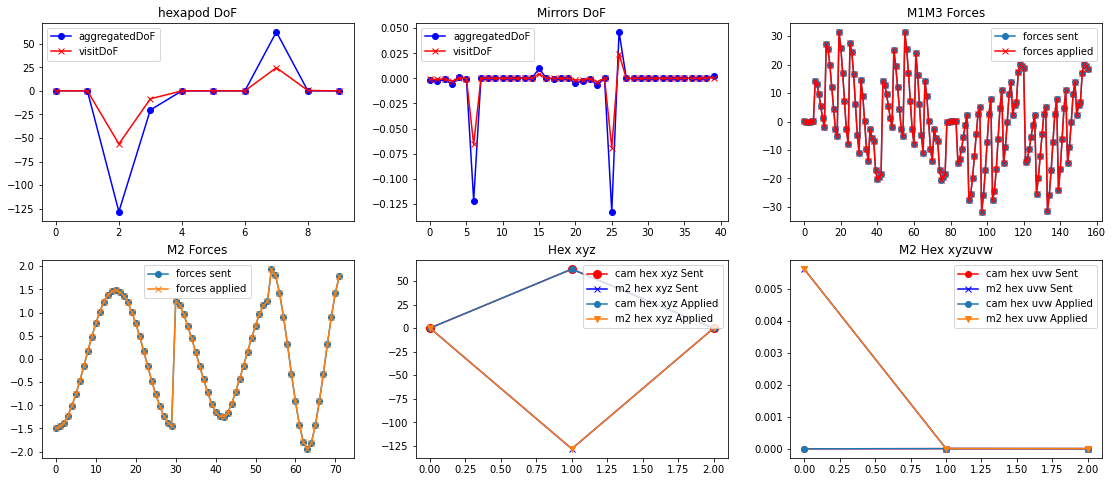

In [105]:
ofc_dict2 = await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot=True)

This depends on the control strategy we are using. For x00, do not expect 2 or 1.

In [106]:
ofc_dict2['camhexC'][:5]/ofc_dict['camhexC'][:5]

array([ 1.5532443 ,  1.6490671 , 10.94577817, -0.0435523 ,  1.19623977])

In [108]:
ofc_dict2['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

array([1.35653437, 1.78411044, 1.2802434 , 1.70934537, 1.49842256])

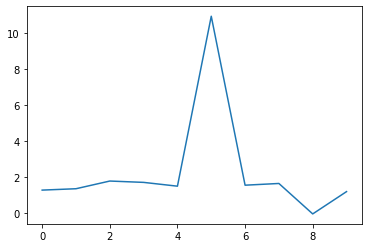

In [109]:
plt.plot(ofc_dict2['aggregated_dof'][:10]/ofc_dict['aggregated_dof'][:10])

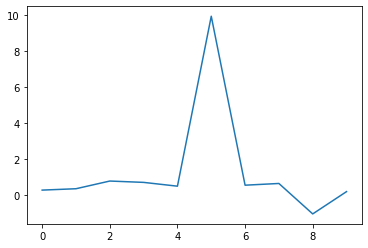

In [110]:
plt.plot(ofc_dict2['visit_dof'][:10]/ofc_dict['visit_dof'][:10])

### Step 3: Reset the corrections

In [111]:
await aos.cmd_resetCorrection.set_start()

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [112]:
##the following should be done by cmd_resetCorrection, but right now this is not the case
await aos.cmd_issueCorrection.set_start() 
#issue the resetted correction, which should be equivalent to the below
#await m1m3.cmd_applyActiveOpticForces.set_start(zForces=[0]*156)
#await m2.cmd_resetForceOffsets.set_start()
#await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)
#await m2hex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

20: Execute do_issueCorrection().
20: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.


DOF event time =  2021-05-04 17:29:33.001132544
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


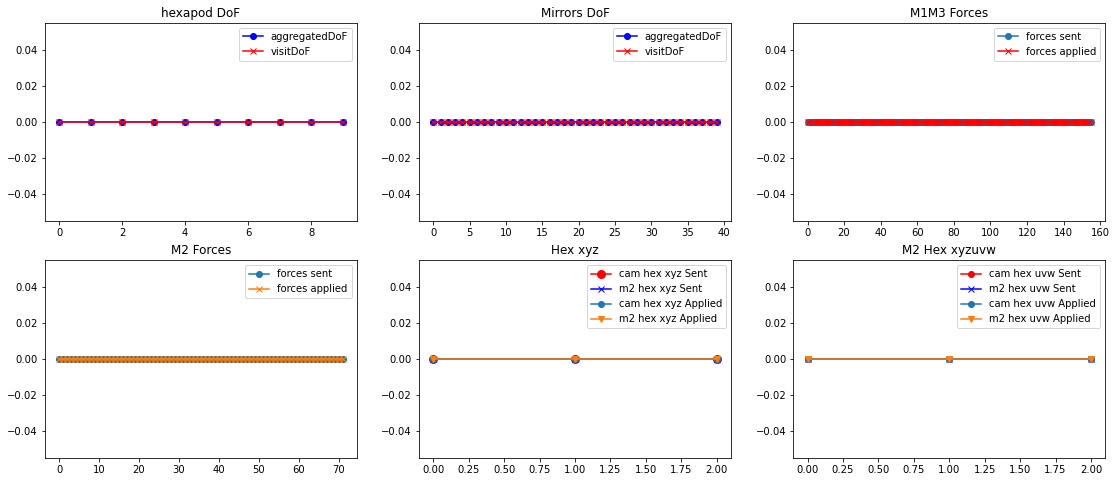

In [114]:
ofc_dict3 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Step 4: Double the aberration, do the corrections double? yes

In [115]:
zernikes[7-4] = 2 # z7 = 2um

In [116]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
20: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-05-04 17:32:44.685912832


electrical DDS read queue is filling: 10 of 100 elements
application DDS read queue is filling: 11 of 100 elements
actuators DDS read queue is filling: 13 of 100 elements


If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


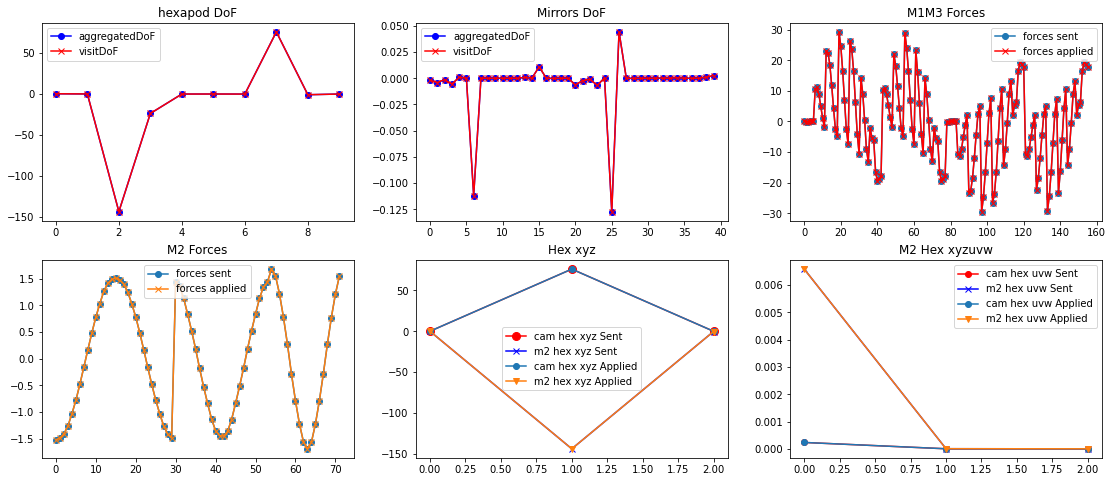

In [118]:
ofc_dict4 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [119]:
ofc_dict4['camhexC'][:5]/ofc_dict['camhexC'][:5]

array([2., 2., 2., 2., 2.])

In [120]:
ofc_dict4['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

array([2., 2., 2., 2., 2.])

### Step 5: Observe the corrections being rejected

In [121]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-05-04 17:34:45.484768256
m1m3 state DetailedState.PARKED 2021-05-04 17:36:37.899777536


In [122]:
#Expect this command to be rejected, because M1M3 is parked
zernikes[7-4] = 1
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
20: Issue the M2 correction successfully.
40: M1M3 correction command failed.
20: Execute pubEvent_rejectedM1M3Correction().
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
20: Execute pubEvent_rejectedDegreeOfFreedom().
30: Undoing camhex correction.
10: Issue the camera hexapod correction successfully.
30: Undoing m2hex correction.
10: Issue the M2 hexapod correction successfully.
30: Undoing m2 correction.
20: Issue the M2 correction successfully.
40: Callback <bound method MtaosCsc.do_addAberration of <lsst.ts.MTAOS.MtaosCsc.MtaosCsc object at 0x7f3dce42a6d0>> failed with data=private_revCode: 8adfd49b, private_sndStamp: 1620149828.5037756, private_rcvStamp: 1620149828.5041912, private_seqNum: 158190986, private_identity: Script:7, private_origin: 6817, private_host: 0, wf: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=158190986, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: Failed to apply correction to: ['m1m3']. ")

#### the addAberration command is supposed to have undone corrections to M2, camhex, and m2hex. Let's check that

DOF event time =  2021-05-04 17:32:44.685912832
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


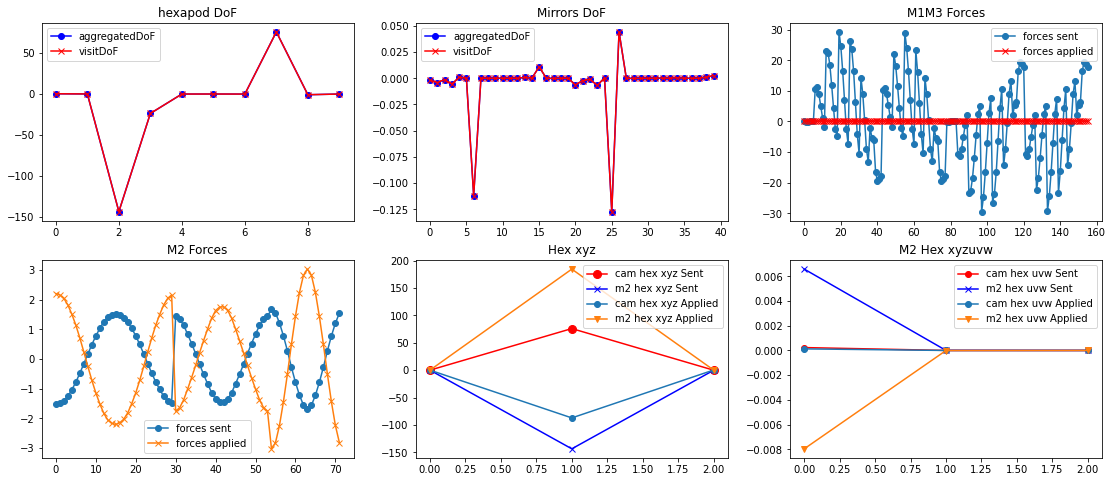

In [124]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [ ]:
print(ofc_dict5['m1m3C'] - ofc_dict4['m1m3C'])
print(ofc_dict5['m2C'] - ofc_dict4['m2C'])
print(ofc_dict5['camhexC'] - ofc_dict4['camhexC'])
print(ofc_dict5['m2hexC'] - ofc_dict4['m2hexC'])

#### What about corrections on the component side?

If the sent already agrees with applied in every case above (they should), checking the sent (=corrections) here is sufficient.

### Step 6: rejectCorrection 

This makes sure OFC does proper accounting when commands are rejected.

When cmd_addAberration doesn't issue corrections, we can test cmd_rejectCorrection. NOT NOW.

In [ ]:
await aos.cmd_rejectCorrection.set_start()

In [ ]:
ofc_dict6 =  await ofcCompSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED,  settingsToApply='Default')

In [ ]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

In [127]:
await salobj.set_summary_state(m2, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [131]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

forceActuatorForceWarning DDS read queue is full (100 elements); data may be lost


In [129]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)